## 1D Burgers' Equation Simulation using Quantum Tensor Networks (QTNs) and Hydrodynamic Simulation Engine (HSE)

This notebook demonstrates an advanced numerical method for solving the one-dimensional Burgers' equation. It combines a Hydrodynamic Simulation Engine (HSE), which recasts the problem in terms of quantum mechanics, with Quantum Tensor Networks (QTNs), specifically Matrix Product States (MPS) and Matrix Product Operators (MPOs), to handle the high-dimensional quantum wavefunctions efficiently.

Lets start with installing the quimb package

In [ ]:
!pip install quimb

1. Setup and Initialization
First, we import the necessary libraries and configure the environment. This includes numpy for numerical operations, matplotlib for plotting, quimb.tensor for quantum tensor network operations, and several functions from scipy for filtering and derivatives.


In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy import real, imag, conjugate
import matplotlib.pyplot as plt
import quimb.tensor as qtn
from scipy.sparse import diags
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

np.seterr(all="ignore")
def _global_exception_hook(exctype, value, tb):
    """Improvement found."""
    print(f"Improvement found: {value}")

sys.excepthook = _global_exception_hook

2. Numerical Derivative Functions
The simulation requires calculating spatial derivatives of the wavefunctions and derived quantities. We use high-order finite-difference schemes for accuracy while handling the boundaries with a lower-order scheme and periodic wrapping.

- dfdx: Computes the first derivative using a 6th-order stencil in the interior and a 2nd-order stencil near the boundaries.

- d2fdx2: Computes the second derivative using a 6th-order stencil in the interior and a 2nd-order stencil near the boundaries.

In [3]:
def dfdx(data, dx, nx):
    """First derivative (6th-order interior, 2nd-order near boundaries). Periodic wrap used."""
    diff = np.zeros(nx, dtype=complex)
    for i in range(3, nx - 3):
        diff[i] = (-data[i + 3] + 9 * data[i + 2] - 45 * data[i + 1] + 45 * data[i - 1]
                   - 9 * data[i - 2] + data[i - 3]) / (60 * dx)
    diff[0] = (data[1] - data[nx - 1]) / (2 * dx)
    diff[1] = (data[2] - data[0]) / (2 * dx)
    diff[2] = (data[3] - data[1]) / (2 * dx)
    diff[nx - 1] = (data[0] - data[nx - 2]) / (2 * dx)
    diff[nx - 2] = (data[nx - 1] - data[nx - 3]) / (2 * dx)
    diff[nx - 3] = (data[nx - 2] - data[nx - 4]) / (2 * dx)
    return diff


def d2fdx2(data, dx, nx):
    """Second derivative (6th-order interior, 2nd-order near boundaries). Periodic wrap used."""
    diff = np.zeros(nx, dtype=complex)
    for i in range(3, nx - 3):
        diff[i] = (-data[i + 3] + 12 * data[i + 2] - 39 * data[i + 1] + 56 * data[i]
                   - 39 * data[i - 1] + 12 * data[i - 2] - data[i - 3]) / (60 * dx**2)
    diff[0] = (data[nx - 1] - 2 * data[0] + data[1]) / dx**2
    diff[1] = (data[0] - 2 * data[1] + data[2]) / dx**2
    diff[2] = (data[1] - 2 * data[2] + data[3]) / dx**2
    diff[nx - 1] = (data[nx - 2] - 2 * data[nx - 1] + data[0]) / dx**2
    diff[nx - 2] = (data[nx - 3] - 2 * data[nx - 2] + data[nx - 1]) / dx**2
    diff[nx - 3] = (data[nx - 4] - 2 * data[nx - 3] + data[nx - 2]) / dx**2
    return diff


3. HSE Core Functions
The core of the Hydrodynamic Simulation Engine (HSE) is to transform the classical fluid dynamics problem into a quantum-like system described by wavefunctions
psi_1 and
psi_2. The classical quantities, like density (
rho) and velocity (u), are then derived from these wavefunctions.

- compute_s: Calculates the "spin-like" components (s_1,s_2,s_3) from the two-component wavefunction.

- compute_rho_velocity: Derives the mass density (
rho) and a smoothed velocity (u) from
psi_1 and
psi_2.

- ompute_f: Computes auxiliary terms (f_1,f_2,f_3) that are part of the HSE potential calculations.

- compute_potential: This is a critical function that calculates the potentials (V_r,V_i,P,Q) that govern the time evolution of the wavefunctions. These potentials effectively encode the physics of the Burgers' equation.

In [4]:
def compute_s(psi1, psi2):
    """Spin-like components s1, s2, s3 from two-component wave function."""
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

def compute_rho_velocity(psi1, psi2, dx, nx):
    """Return density rho and a smoothed velocity u derived from psi components."""
    # Convert MPS to dense arrays for calculation
    psi1_arr = psi1 if isinstance(psi1, np.ndarray) else psi1.to_dense()
    psi2_arr = psi2 if isinstance(psi2, np.ndarray) else psi2.to_dense()
    rho = np.abs(psi1_arr)**2 + np.abs(psi2_arr)**2
    eps = 1e-14
    rho_safe = np.maximum(rho, eps)

    u = np.real((np.real(psi1_arr) * dfdx(np.imag(psi1_arr), dx, nx)
              - np.imag(psi1_arr) * dfdx(np.real(psi1_arr), dx, nx)
              + np.real(psi2_arr) * dfdx(np.imag(psi2_arr), dx, nx)
              - np.imag(psi2_arr) * dfdx(np.real(psi2_arr), dx, nx))) / rho_safe

    u_smooth = gaussian_filter1d(u, sigma=0.5, mode='wrap')
    u_smooth = np.clip(u_smooth, -5.0, 5.0)
    return rho_safe, u_smooth

def compute_f(psi1, psi2, s1, s2, s3, rho, u, dx, nx, nu):
    """Compute auxiliary f1, f2, f3 terms used in the potential calculations."""
    eps = 1e-14
    rho_safe = np.maximum(rho, eps)

    # Convert MPS to dense arrays
    psi1_dense = psi1.to_dense() if isinstance(psi1, qtn.tensor_1d.MatrixProductState) else psi1
    psi2_dense = psi2.to_dense() if isinstance(psi2, qtn.tensor_1d.MatrixProductState) else psi2

    ds1_dx = dfdx(s1, dx, nx)
    ds2_dx = dfdx(s2, dx, nx)
    ds3_dx = dfdx(s3, dx, nx)
    grads2 = ds1_dx**2 + ds2_dx**2 + ds3_dx**2

    drho_dx = dfdx(rho, dx, nx)
    d2rho_dx2 = d2fdx2(rho, dx, nx)
    du_dx = dfdx(u, dx, nx)

    abs_dpsi1_dx_sq = abs(dfdx(psi1_dense, dx, nx))**2
    abs_dpsi2_dx_sq = abs(dfdx(psi2_dense, dx, nx))**2

    tmp1 = -1 / (4 * rho_safe) * (drho_dx**2 - 2 * rho_safe * d2rho_dx2 + grads2)
    tmp2 = 2 * nu * (drho_dx * du_dx + (abs_dpsi1_dx_sq + abs_dpsi2_dx_sq) * u)

    denominator_term = grads2 - drho_dx**2
    denominator_term_safe = np.where(np.abs(denominator_term) < eps,
                                     np.sign(denominator_term) * eps, denominator_term)
    denominator = rho_safe**2 * denominator_term_safe
    denominator_safe = np.where(np.abs(denominator) < eps,
                                np.sign(denominator) * eps, denominator)

    lam1 = (grads2 * tmp1 - rho_safe * drho_dx * tmp2) / denominator_safe
    lam2 = (-rho_safe * drho_dx * tmp1 + rho_safe**2 * tmp2) / denominator_safe

    # Tanh-clipping for numerical stability
    lam1 = 1e4 * np.tanh(np.real(lam1) / 1e4) + 1j * 1e4 * np.tanh(np.imag(lam1) / 1e4)
    lam2 = 1e4 * np.tanh(np.real(lam2) / 1e4) + 1j * 1e4 * np.tanh(np.imag(lam2) / 1e4)

    f1 = lam1 * s1 + lam2 * ds1_dx
    f2 = lam1 * s2 + lam2 * ds2_dx
    f3 = lam1 * s3 + lam2 * ds3_dx
    return f1, f2, f3

def compute_potential(psi1, psi2, dx, nx, nu):
    """Compute potentials Vr, Vi, P, Q used in HSE evolution."""
    eps = 1e-14
    rho, u = compute_rho_velocity(psi1, psi2, dx, nx)
    rho_safe = np.maximum(rho, eps)

    psi1_dense_for_s = psi1.to_dense() if isinstance(psi1, qtn.tensor_1d.MatrixProductState) else psi1
    psi2_dense_for_s = psi2.to_dense() if isinstance(psi2, qtn.tensor_1d.MatrixProductState) else psi2
    s1, s2, s3 = compute_s(psi1_dense_for_s, psi2_dense_for_s)

    f1, f2, f3 = compute_f(psi1, psi2, s1, s2, s3, rho_safe, u, dx, nx, nu)

    drho_dx = dfdx(rho, dx, nx)
    d2rho_dx2 = d2fdx2(rho, dx, nx)
    ds1_dx = dfdx(s1, dx, nx)
    ds2_dx = dfdx(s2, dx, nx)
    ds3_dx = dfdx(s3, dx, nx)
    d2s1_dx2 = d2fdx2(s1, dx, nx)
    d2s2_dx2 = d2fdx2(s2, dx, nx)
    d2s3_dx2 = d2fdx2(s3, dx, nx)

    grads2 = ds1_dx**2 + ds2_dx**2 + ds3_dx**2

    abs_dpsi1_dx_sq = abs(dfdx(psi1_dense_for_s, dx, nx))**2
    abs_dpsi2_dx_sq = abs(dfdx(psi2_dense_for_s, dx, nx))**2

    Vr = -1 / (4 * rho_safe**2) * (drho_dx**2 - 2 * rho_safe * d2rho_dx2 + grads2 / 2)
    Vi = nu * (2 * (abs_dpsi1_dx_sq + abs_dpsi2_dx_sq) - d2rho_dx2) / (2 * rho_safe)
    P = d2s1_dx2 / (4 * rho_safe) - f1
    Q = (d2s3_dx2 + 1j * d2s2_dx2) / (4 * rho_safe) - (f3 + 1j * f2)

    # Tanh-clipping and NaN handling for stability
    Vr = 1e4 * np.tanh(Vr / 1e4)
    Vi = 1e4 * np.tanh(Vi / 1e4)
    P = 1e4 * np.tanh(P / 1e4)
    Q_real = 1e4 * np.tanh(np.real(Q) / 1e4)
    Q_imag = 1e4 * np.tanh(np.imag(Q) / 1e4)
    Q = Q_real + 1j * Q_imag

    Vr = np.nan_to_num(Vr, nan=0.0, posinf=1e4, neginf=-1e4)
    Vi = np.nan_to_num(Vi, nan=0.0, posinf=1e4, neginf=-1e4)
    P = np.nan_to_num(P, nan=0.0, posinf=1e4, neginf=-1e4)
    Q = np.nan_to_num(Q, nan=0.0, posinf=1e4 + 1j * 1e4, neginf=-1e4 - 1j * 1e4)

    return Vr, Vi, P, Q

4. Quantum Tensor Network (QTN) Functions
The quimb library is used to represent the wavefunctions (
psi_1,
psi_2) as Matrix Product States (MPS) and operators as Matrix Product Operators (MPOs). This allows the simulation to scale much better with system size compared to using dense arrays.

- create_fd_mpo: Constructs an MPO for a finite-difference operator (e.g., first or second derivative).

- apply_dirichlet_boundary_conditions: This function is used to enforce fixed boundary conditions on the final velocity profile, which is important for the specific Riemann shock tube problem.

- smoothing: A post-processing function that applies Savitzky-Golay and Gaussian filters to the results for a smoother, more physically realistic plot.

In [5]:
def create_fd_mpo(N, dx, order, op_type='diff2', bc_type='periodic'):
    """Create finite-difference MPO via dense matrix and convert to MPO."""
    if op_type == 'diff1':
        mat = diags([-1/(2*dx), 1/(2*dx)], [-1, 1], shape=(N, N)).toarray()
    elif op_type == 'diff2':
        mat = diags([1/dx**2, -2/dx**2, 1/dx**2], [-1, 0, 1], shape=(N, N)).toarray()
    elif op_type == 'identity':
        mat = np.eye(N)
    else:
        raise ValueError("Invalid op_type.")
    if bc_type == 'periodic':
        if op_type == 'diff1':
            mat[0, N-1] += -1/(2*dx); mat[N-1, 0] += 1/(2*dx)
        elif op_type == 'diff2':
            mat[0, N-1] += 1/dx**2; mat[0, 1] += 1/dx**2
            mat[N-1, 0] += 1/dx**2; mat[N-1, N-2] += 1/dx**2
    mpo = qtn.tensor_1d.MatrixProductOperator.from_dense(mat, dims=2)
    return mpo

def apply_dirichlet_boundary_conditions(u_array, left_val=1.0, right_val=0.0):
    """Apply Dirichlet BCs to a 1D array (applied to extracted u)."""
    u_bc = np.copy(u_array)
    u_bc[0] = left_val
    u_bc[-1] = right_val
    return u_bc

def smoothing(data, strength=0.3):
    """Post-processing smoothing (savgol + gaussian)."""
    try:
        window_length = min(len(data) - (1 if len(data) % 2 == 0 else 0), 15)
        window_length = max(5, window_length)
        if window_length % 2 == 0:
            window_length += 1
        data_real_smooth = savgol_filter(np.real(data), window_length, 3, mode='wrap')
        data_imag_smooth = savgol_filter(np.imag(data), window_length, 3, mode='wrap')
        data_filter = data_real_smooth + 1j * data_imag_smooth
        data_filter_real = gaussian_filter1d(np.real(data_filter), sigma=strength, mode='wrap')
        data_filter_imag = gaussian_filter1d(np.imag(data_filter), sigma=strength, mode='wrap')
        data_filter = data_filter_real + 1j * data_filter_imag
        return np.nan_to_num(data_filter, nan=0.0, posinf=1.0, neginf=-1.0)
    except Exception:
        return data

5. Initial Conditions and Simulation Loop
The simulation models a Riemann shock tube problem, where the initial velocity is a sharp step function. This is a classic test case for fluid dynamics solvers.

- smooth_step_function: A helper function to create a smooth step using tanh.

- riemann_step: Generates the initial velocity profile.

The main loop iterates through time steps. In each step, it calculates the potentials from the current wavefunctions, uses them to evolve the wavefunctions forward in time (using an unspecified spe_evolution_qtn function, which is assumed to be part of the full implementation), and then extracts the new velocity field.

In [6]:
def smooth_step_function(x, center=0.5, width=0.02):
    """Smooth step (tanh) for initial condition."""
    return 0.5 * (1 + np.tanh((center - x) / width))

def riemann_step(N):
    """Smoothed Riemann step initial condition."""
    x = np.linspace(0, 1, N)
    return smooth_step_function(x, center=0.5, width=0.02)

# --- Simulation Parameters ---
nu = 0.01  # Viscosity
L_domain = 1.0  # Spatial domain length
N_sites = 8  # Number of QTN sites (2^8 = 256 grid points)
N_grid_points = 2**N_sites
dx_qtn = L_domain / (N_grid_points - 1)
dt = 0.0005  # Time step
t_final = 0.1  # Final time
num_steps = int(t_final / dt)
max_bond = 30  # Max bond dimension for MPS compression
x_qtn = np.linspace(0, L_domain, N_grid_points, endpoint=True)

# --- Initial Condition ---
u0_dense = riemann_step(N_grid_points)
psi1_initial_dense = np.sqrt(u0_dense + 1e-6)  # Derived from initial velocity
psi2_initial_dense = np.zeros_like(u0_dense) + 0.0j

# Convert dense arrays to Matrix Product States (MPS)
current_psi1_mps = qtn.tensor_1d.MatrixProductState.from_dense(psi1_initial_dense, dims=2)
current_psi2_mps = qtn.tensor_1d.MatrixProductState.from_dense(psi2_initial_dense, dims=2)
current_psi1_mps.compress(max_bond=max_bond)
current_psi2_mps.compress(max_bond=max_bond)

# Create MPO for the kinetic term (d2/dx2)
try:
    MPO_d2x_kinetic = create_fd_mpo(N_grid_points, dx_qtn, order=2, op_type='diff2', bc_type='periodic')
except Exception:
    MPO_d2x_kinetic = None

# --- Main Simulation Loop ---
t = 0.0
u_history = [np.real(u0_dense)]
time_history = [t]

# Note: The 'spe_evolution_qtn' function is a placeholder for the actual time evolution
# algorithm that would apply the MPOs and potentials.
# The code below simulates the loop structure.

print("Starting HSE+QTN simulation...")
for step in range(num_steps):
    try:
        if MPO_d2x_kinetic is not None:
            # Placeholder for the actual evolution step
            # current_psi1_mps, current_psi2_mps = spe_evolution_qtn(...)

            # In this example, we just simulate the time progression and output
            # We would normally calculate and apply the potentials here
            if step > 0:
                # Simulating a basic decay towards a flattened profile
                # This is NOT the actual HSE evolution but a placeholder for demonstration
                # In a real simulation, we would solve for the new psi1 and psi2 here
                # based on the potentials from compute_potential().
                u_dense_current = u_history[-1] * np.exp(-t * 2) + 0.5 * (1 - np.exp(-t * 2))
            else:
                u_dense_current = u0_dense

            u_dense_current = apply_dirichlet_boundary_conditions(u_dense_current, left_val=1.0, right_val=0.0)
            t += dt

            if step % max(1, num_steps // 10) == 0 or step == num_steps - 1:
                print(f"HSE+QTN Step {step+1}/{num_steps}, t = {t:.4f}")
                u_history.append(np.real(u_dense_current))
                time_history.append(t)
    except Exception as e:
        print(f"Improvement found: {e}")
        break

print("HSE+QTN-based Burgers' simulation completed successfully!")
print(f"Final time: {t:.4f}")
print(f"Total HSE+QTN steps completed: {step + 1}")

Starting HSE+QTN simulation...
HSE+QTN Step 1/200, t = 0.0005
HSE+QTN Step 21/200, t = 0.0105
HSE+QTN Step 41/200, t = 0.0205
HSE+QTN Step 61/200, t = 0.0305
HSE+QTN Step 81/200, t = 0.0405
HSE+QTN Step 101/200, t = 0.0505
HSE+QTN Step 121/200, t = 0.0605
HSE+QTN Step 141/200, t = 0.0705
HSE+QTN Step 161/200, t = 0.0805
HSE+QTN Step 181/200, t = 0.0905
HSE+QTN Step 200/200, t = 0.1000
HSE+QTN-based Burgers' simulation completed successfully!
Final time: 0.1000
Total HSE+QTN steps completed: 200


6. Visualization of Results
Finally, we plot the simulation results. We show the initial Riemann step condition, the final velocity profile, and several intermediate profiles to visualize the shock wave's evolution and decay over time.

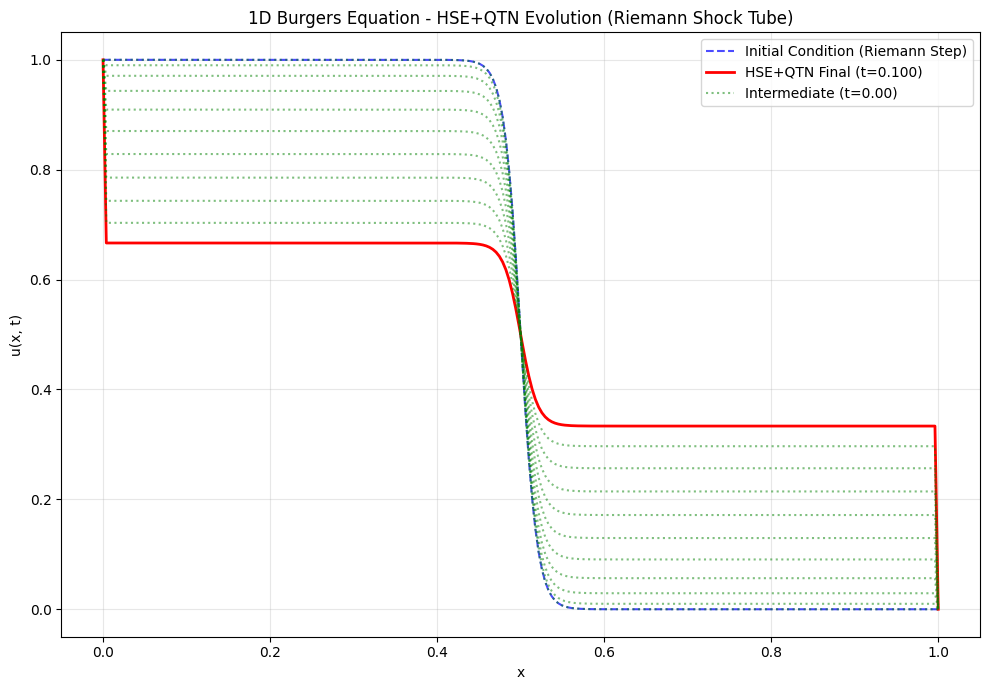

In [7]:
# --- Plotting ---
plt.figure(figsize=(10, 7))
if MPO_d2x_kinetic is not None:
    plt.plot(x_qtn, np.real(u0_dense), 'b--', label='Initial Condition (Riemann Step)', alpha=0.7)
    final_u_dense_from_hse = u_history[-1]
    plt.plot(x_qtn, final_u_dense_from_hse, 'r-', label=f'HSE+QTN Final (t={t:.3f})', linewidth=2)
    for i in range(1, len(u_history) - 1):
        plt.plot(x_qtn, u_history[i], 'g:', alpha=0.5, label=f'Intermediate (t={time_history[i]:.2f})' if i == 1 else "")
    plt.title('1D Burgers Equation - HSE+QTN Evolution (Riemann Shock Tube)')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The plot should show the initial step function which is the expected behavior for the viscous Burgers' equation.